# Deep Q-Network (DQN)
---
We implement a Deep Q-Network agent using OpenAI Gym's LunarLander-v2.

### 1. Import the Necessary Packages

In [1]:
import gym
#!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#!pip install xvfbwrapper
#!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


### 2. Instantiate the Environment and Agent



In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/home/pablo/.pyenv/versions/3.6.10/envs/deepRL/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Neural network - Before defining Agent

In [3]:
from model import QNetwork
#from torchsummary import summary

modeltest = QNetwork(8,4, 1, nu = [32,64,64, 128], dropout = 0.3)

#summary(model_scratch, input_size = (8,4))

### Agent

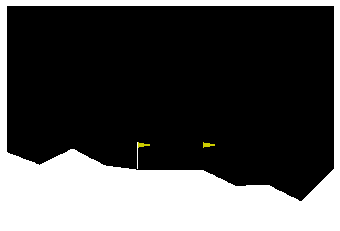

In [4]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, 
              seed=0, nu = [32,64,64, 64])

# watch an untrained agent
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(200):
    action = agent.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN


In [5]:
def dqn(agent, n_episodes=2000, max_t=1000, 
        eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_online.state_dict(), 'checkpoint.pth')
            break
    return scores

Episode 100	Average Score: -179.17
Episode 200	Average Score: -103.87
Episode 300	Average Score: -80.008
Episode 400	Average Score: -103.42


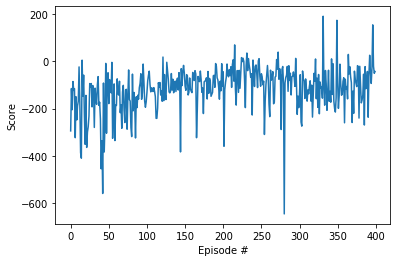

In [5]:
scores = dqn(agent, 400)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
scores2 = dqn(agent, 1600, max_t= 500)


Episode 100	Average Score: -106.71
Episode 200	Average Score: -28.886
Episode 300	Average Score: 51.743
Episode 400	Average Score: 126.23
Episode 500	Average Score: 185.65
Episode 539	Average Score: 200.51
Environment solved in 439 episodes!	Average Score: 200.51


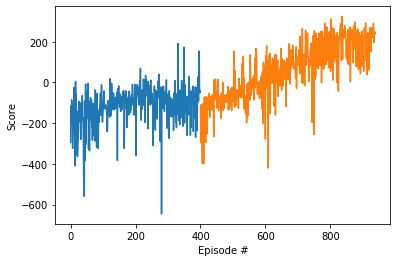

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores2))+len(scores), scores2)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
torch.save(agent.qnetwork_online.state_dict(), 'DQN-checkpoint.pth')
            

### 4. Smart Agent


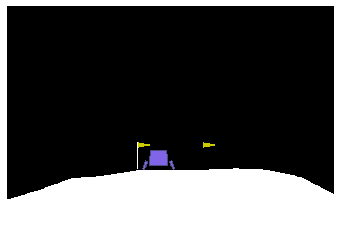

In [9]:
# load the weights from file

agent.qnetwork_online.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(400):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

# Double Q-learning!

In [10]:
from dqn_agent import AgentDoubleQ
import torch.optim as optim

class AgentDoubleQ(Agent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, nu = None, dropout = None ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """    
        super().__init__(state_size, action_size, seed, nu, dropout)
        self.optimizer = optim.Adam(self.qnetwork_online.parameters(), 
                                    lr=.5e-4)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        qtargetnext, argnext = torch.max(self.qnetwork_online(next_states).detach(),1)
        # This line introduces the double Q-learning, another way would be using another
        # network
        qonlinenext =  self.qnetwork_target(next_states).detach().gather(1,argnext.unsqueeze(1))
        
        qtarget = rewards + gamma*qonlinenext*(1-dones)
        
        qexpect = self.qnetwork_online(states).gather(1,actions)
        
        loss = self.criterion(qexpect, qtarget)
        
        # Update parameters and gradients to zero
        # Compute the gradients
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()


In [11]:

doubleagent = AgentDoubleQ(state_size=8, action_size=4, 
              seed=0, nu = [32,64,64, 256])


In [12]:
scoreD1 = dqn(doubleagent, 1000, max_t = 500)

Episode 100	Average Score: -210.83
Episode 200	Average Score: -285.07
Episode 300	Average Score: -251.15
Episode 400	Average Score: -303.97
Episode 500	Average Score: -219.47
Episode 600	Average Score: -157.96
Episode 700	Average Score: -185.37
Episode 800	Average Score: -617.13
Episode 900	Average Score: -514.42
Episode 1000	Average Score: -127.02


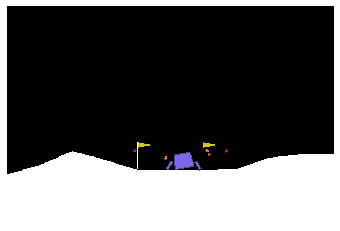

In [13]:
for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(400):
        action = doubleagent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

In [8]:
from model import DuelQNetwork
from dqn_agent import AgentDoubleQ

In [9]:
agentDuelDQN = Agent(state_size=8, action_size=4, 
              seed=0, nu = [32,64,64, 128], model = DuelQNetwork)

In [10]:
scoreDuelDQN1 = dqn(agentDuelDQN, 1000, max_t = 500)

Episode 100	Average Score: -189.41
Episode 200	Average Score: -91.476
Episode 300	Average Score: -17.17
Episode 400	Average Score: -23.12
Episode 500	Average Score: 17.437
Episode 600	Average Score: 59.74
Episode 700	Average Score: 73.05
Episode 800	Average Score: 72.97
Episode 900	Average Score: 85.26
Episode 1000	Average Score: 106.92


In [11]:
scoreDuelDQN2 = dqn(agentDuelDQN, 500, max_t = 500)

Episode 100	Average Score: -124.09
Episode 200	Average Score: -25.443
Episode 300	Average Score: 115.76
Episode 400	Average Score: 162.28
Episode 450	Average Score: 200.41
Environment solved in 350 episodes!	Average Score: 200.41


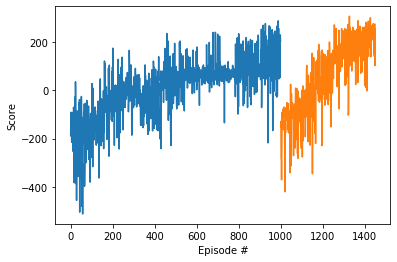

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scoreDuelDQN1)), scoreDuelDQN1)
plt.plot(np.arange(len(scoreDuelDQN2))+len(scoreDuelDQN1), scoreDuelDQN2)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
# load the weights from file
torch.save(agentDuelDQN.qnetwork_online.state_dict(), 'DuelDQN-checkpoint.pth')

In [6]:
def showngames(agent, n = 3, tlim = 400):
    agent.qnetwork_online.load_state_dict(torch.load('DuelDQN-checkpoint.pth'))

    for i in range(n):
        state = env.reset()
        img = plt.imshow(env.render(mode='rgb_array'))
        for j in range(tlim):
            action = agent.act(state)
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state, reward, done, _ = env.step(action)
            if done:
                break 

    env.close()
    

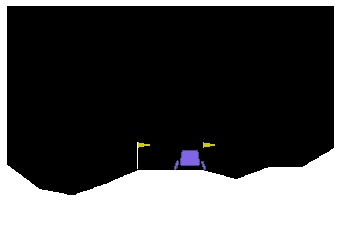

In [10]:
showngames(agentDuelDQN)

In [12]:
agentDDDQN = AgentDoubleQ(state_size=8, action_size=4, 
              seed=0, nu = [32,64,64, 128], model = DuelQNetwork)

In [15]:
scoreDDDQN1 = dqn(agentDDDQN, 500, max_t = 500)

Episode 100	Average Score: -152.17
Episode 200	Average Score: -172.13
Episode 300	Average Score: -132.56
Episode 400	Average Score: -84.057
Episode 500	Average Score: -224.74


In [20]:
scoreDDDQN1 = dqn(agentDDDQN, 500, max_t = 500)

Episode 100	Average Score: -144.02
Episode 200	Average Score: -88.556
Episode 300	Average Score: -84.68
Episode 400	Average Score: -102.35
Episode 500	Average Score: -92.175


In [19]:
np.random.sample?